# Zembo City expansion

There are "Franchise (cabinets)", "Internal Grid", "Internal Hybrid".

Constraints:
- All Franchise cabintes should be placed
- Franchise cabinets are placed in cities themselves with population greater than average population.
- maximum: 30 Internal Hybrid, 20 Internal Grid, and 20 franchise cabinets
- Hybrid should be placed in priority on the roads. then place internal grid.
- more than 1 franchise can be placed per town but not all can be franchise in one town
- each city that can have a cabinet should have atleast one.
- Each route should have atleast 1 hybrid

placement:

- first: place cabinet in city if possible
- second: place hybrid on road 
- third: Place grid station for the rest.



In [7]:
import gurobipy as gb
from gurobipy import GRB, quicksum
import pandas as pd
import math

# Load the dataset containing city information
df_uploaded = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/4 - Case Competition/Zembo/Round 2/Optimisation/Data Uganda Optimisation - Felix.csv")

# Extract relevant data columns into separate lists for further processing
City = df_uploaded['City'].tolist()  # List of city names
Population = df_uploaded['Population'].tolist()  # Corresponding population sizes
Distance = df_uploaded['Dist from previous'].tolist()  # Distance from the previous city
Route_Color = df_uploaded['Route Color'].tolist()  # Route color associated with each city
ID = df_uploaded['ID'].tolist()  # Unique identifier for each city
PreviousID = df_uploaded['Previous ID'].tolist()  # Previous city ID for each city

# Define the maximum number of cities, stations, and franchise cabinets
Max_Cities = 50  # Maximum number of cities to include (excluding Kampala)
Max_Franchise = 20  # Maximum number of franchise cabinets to place
Max_Hybrid = 30 - 10  # Maximum number of internal Hybrid stations (adjusted for existing installations)
Max_Grid = 20  # Maximum number of internal Grid stations
Max_Franchise_Per_City = stpercity - 1  # Maximum number of franchise cabinets per city

# Define other key parameters
stpercity = 5  # Number of stations required per city
stperkm = 30   # Number of stations needed per given distance (in km)

Num_Cities = len(City)  # Total number of cities

# Calculate the average population to assist with franchise cabinet placement
avg_population = sum(Population) / Num_Cities

# Create a dictionary to map each city's ID to its index in the variables list
id_to_index = {ID[i]: i for i in range(Num_Cities)}

# Initialize the optimization model with Gurobi
model = gb.Model("City_Expansion")
model.setParam('MIPGap', 0.00001)  # Set the minimum gap tolerance for the solution
model.Params.OutputFlag = 0  # Suppress Gurobi output during optimization

# Define binary decision variables (x[i]) to indicate if a city is selected for expansion
x = model.addVars(Num_Cities, lb=0, ub=1, vtype=GRB.BINARY, name=[City[i] for i in range(Num_Cities)])

# Define integer variables for the three types of stations: franchise, grid, and hybrid
y_franchise = model.addVars(Num_Cities, lb=0, ub=Max_Franchise_Per_City, vtype=GRB.INTEGER, name=[f"Franchise_{City[i]}" for i in range(Num_Cities)])
y_grid = model.addVars(Num_Cities, lb=0, vtype=GRB.INTEGER, name=[f"Grid_{City[i]}" for i in range(Num_Cities)])
y_hybrid = model.addVars(Num_Cities, lb=0, vtype=GRB.INTEGER, name=[f"Hybrid_{City[i]}" for i in range(Num_Cities)])

# Objective function: Maximize the total population covered while minimizing station installation costs
exp = quicksum(x[i] * Population[i] for i in range(1, Num_Cities)) - quicksum(y_grid[i] + y_hybrid[i] + y_franchise[i] for i in range(1, Num_Cities))
model.setObjective(exp, GRB.MAXIMIZE)

# Constraints
model.addConstr(quicksum(x[i] for i in range(1, Num_Cities)) <= Max_Cities, name="Max_Cities_constraint")  # Ensure the total number of selected cities doesn't exceed the maximum limit
model.addConstr(quicksum(y_franchise[i] for i in range(Num_Cities)) == Max_Franchise, name="Total_Franchise_Placed")  # Ensure the exact number of franchise cabinets is placed
model.addConstr(quicksum(y_grid[i] for i in range(Num_Cities)) <= Max_Grid, name="Max_Grid_constraint")  # Limit the total number of grid stations
model.addConstr(quicksum(y_hybrid[i] for i in range(Num_Cities)) <= Max_Hybrid, name="Max_Hybrid_constraint")  # Limit the total number of hybrid stations
model.addConstr(x[0] >= 1, name="Kampala_Selection_constraint")  # Ensure that Kampala (city 0) is always selected

# Limit the maximum number of franchise cabinets per city
for i in range(Num_Cities):
    model.addConstr(y_franchise[i] <= Max_Franchise_Per_City, name=f"Max_Franchise_Per_City_{City[i]}")

# Ensure city selection dependencies: If a city is selected, its previous city must also be selected
for i in range(Num_Cities):
    if not pd.isna(PreviousID[i]) and PreviousID[i] in id_to_index:
        prev_id_index = id_to_index[PreviousID[i]]
        model.addConstr(x[i] <= x[prev_id_index], name=f"City_Selection_Dependency_{City[i]}")

# Loop over cities (starting from index 1 to exclude Kampala) to add more constraints based on specific requirements
for i in range(1, Num_Cities):
    distance = Distance[i]  # Distance from the previous city
    required_stations = math.ceil(stpercity + distance / stperkm)  # Calculate required stations based on distance

    # Place franchise cabinets in cities with high population while adhering to city constraints
    model.addConstr(y_franchise[i] <= x[i] * Max_Franchise_Per_City, name=f"Franchise_Placement_{City[i]}")

    # Ensure that each city has at least one hybrid station if it is selected
    model.addConstr(y_hybrid[i] >= x[i], name=f"Hybrid_Minimum_{City[i]}")

    # Ensure the total number of stations required per city is met
    model.addConstr(y_hybrid[i] + y_grid[i] + y_franchise[i] >= required_stations * x[i], name=f"Total_Stations_{City[i]}")

model.addConstr(quicksum(y_franchise[i] for i in range(Num_Cities)) <= Max_Franchise, name="Total_Franchise_Placed")  # Ensure the total franchise placements are within the maximum limit

# Optimize the model to find the best solution
model.optimize()

# Output results if an optimal solution is found
if model.status == GRB.OPTIMAL:
    # Calculate and print the results
    total_franchise = sum(y_franchise[i].x for i in range(Num_Cities))
    total_grid = sum(y_grid[i].x for i in range(Num_Cities))
    total_hybrid = sum(y_hybrid[i].x for i in range(Num_Cities))
    total_cities_chosen = sum(x[i].x for i in range(1, Num_Cities))
    total_population = sum(x[i].x * Population[i] for i in range(1, Num_Cities))

    print("-" * 70)
    print("--- Zembo New City Route Options Planning Gurobi Optimization: ---\n")
    print("       The Parameters are:")
    print(f"The Maximum number of cities is: {Max_Cities}")
    print(f"Maximum Franchise Cabinets: {Max_Franchise}, Internal Grid: {Max_Grid}, Internal Hybrid: {Max_Hybrid}\n")
    print("-" * 50 + "\n")

    # Print total summary of the optimized solution
    print("      The New Zembo Market is:\n")
    print(f"Total Franchise cabinets placed: {total_franchise}")
    print(f"Total Internal Grid stations placed: {total_grid}")
    print(f"Total Internal Hybrid stations placed: {total_hybrid}")
    print(f"Total cities chosen are: {total_cities_chosen}")
    print(f"Total population reached is: {total_population}\n")
    print("-" * 50 + "\n")

    # Print detailed results for each selected city
    print("    The New cities to be covered by Zembo are:\n")
    for i in range(1, Num_Cities):  # Start from 1 to exclude Kampala
        if x[i].x > 0.5:  # City is selected if x[i] > 0
            city = City[i]
            route = Route_Color[i]
            population_touched = Population[i]
            print(f"{city} --- on route --- {route} --- was selected.")
            print(f"   Population reached: {population_touched}")
            print(f"   Franchise: {y_franchise[i].x}, Grid: {y_grid[i].x}, Hybrid: {y_hybrid[i].x}\n")

else:
    print("No optimal solution found.")


Set parameter MIPGap to value 1e-05


----------------------------------------------------------------------
--- Zembo New City Route Options Planning Gurobi Optimization: ---

       The Parameters are:
The Maximum number of cities is: 50
Maximum Franchise Cabinets: 20, Internal Grid: 20, Internal Hybrid: 20

--------------------------------------------------

      The New Zembo Market is:

Total Franchise cabinets placed: 20.0
Total Internal Grid stations placed: 20.0
Total Internal Hybrid stations placed: 17.0
Total cities chosen are: 8.0
Total population reached is: 877343.0

--------------------------------------------------

    The New cities to be covered by Zembo are:

Buwama --- on route --- Green --- was selected.
   Population reached: 57800
   Franchise: -0.0, Grid: 6.0, Hybrid: 2.0

Masaka --- on route --- Green --- was selected.
   Population reached: 0
   Franchise: -0.0, Grid: -0.0, Hybrid: 7.0

Mbirizi --- on route --- Green --- was selected.
   Population reached: 0
   Franchise: 4.0, Grid: 2.0, Hybrid:

    The New cities to be covered by Zembo are:



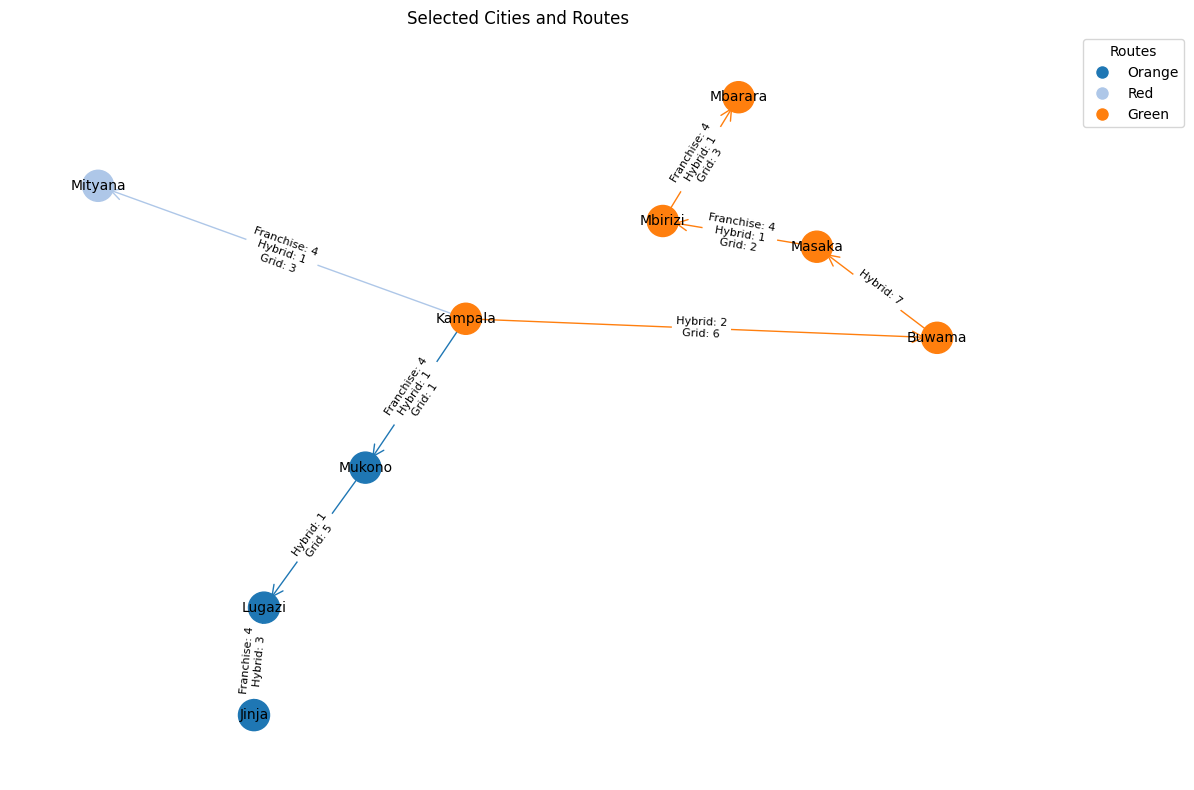

In [8]:
import math
import networkx as nx
import matplotlib.pyplot as plt

# Print details for each city
print("    The New cities to be covered by Zembo are:\n")
selected_cities = []
for i in range(Num_Cities):
    if x[i].x > 0.5:  # City is selected if x[i] > 0.5
        city = City[i]
        route = Route_Color[i]
        population_touched = Population[i]

        selected_cities.append(i)

# Create a color map for routes
unique_routes = list(set(Route_Color[i] for i in selected_cities))
route_colors = {}
cmap = plt.get_cmap('tab20')  # Use a colormap with enough distinct colors
for idx, route in enumerate(unique_routes):
    route_colors[route] = cmap(idx % 20)  # Ensure index does not exceed colormap size

# Create a graph of the selected cities and routes
G = nx.DiGraph()

# Add nodes for the selected cities with colors based on Route_Color
node_colors = []
for i in selected_cities:
    city_name = City[i]
    G.add_node(city_name)
    route = Route_Color[i]
    node_colors.append(route_colors[route])

# Prepare edge labels for charging stations
edge_labels = {}

# Add edges based on the 'Previous ID' field
for i in selected_cities:
    if not pd.isna(PreviousID[i]) and PreviousID[i] in id_to_index:
        prev_index = id_to_index[PreviousID[i]]
        if x[prev_index].x > 0.5:  # Add edge only if the previous city is also selected
            from_city = City[prev_index]
            to_city = City[i]
            G.add_edge(from_city, to_city)

            # Determine the type and number of charging stations between nodes
            # Assuming the stations required between cities are associated with the route segment
            # Here, we distribute the city's stations along the incoming edge
            num_franchise = y_franchise[i].x
            num_hybrid = y_hybrid[i].x
            num_grid = y_grid[i].x

            # Create a label with the station information
            label = ""
            if num_franchise > 0:
                label += f"Franchise: {int(num_franchise)}\n"
            if num_hybrid > 0:
                label += f"Hybrid: {int(num_hybrid)}\n"
            if num_grid > 0:
                label += f"Grid: {int(num_grid)}"

            edge_labels[(from_city, to_city)] = label

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw nodes with colors based on Route_Color
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Prepare edge colors based on route colors
edge_colors = []
for (u, v) in G.edges():
    # Assuming the route is determined by the destination city
    idx = City.index(v)
    route = Route_Color[idx]
    edge_colors.append(route_colors[route])

# Draw edges with colors based on Route_Color
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color=edge_colors)

# Add edge labels for charging station information
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

# Create a legend for routes
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=route,
                          markerfacecolor=route_colors[route], markersize=10)
                   for route in unique_routes]
plt.legend(handles=legend_elements, title='Routes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Selected Cities and Routes')
plt.axis('off')
plt.tight_layout()
plt.show()
